# Experiments

In [1]:
from pryngles import *
%load_ext autoreload
%autoreload 2

## Refactoring tests

In [8]:
Consts.get_all()

['ABC',
 'BODY_DEFAULTS',
 'BODY_KINDS',
 'DATA_INDEX',
 'DEG',
 'DOUBLE',
 'FILE',
 'GSI',
 'HASH_MAXSIZE',
 'IN_JUPYTER',
 'LEGACY_PHYSICAL_PROPERTIES',
 'NORMFACTOR',
 'OBSERVER_DEFAULTS',
 'PDOUBLE',
 'PLANET_DEFAULTS',
 'PPDOUBLE',
 'PPPDOUBLE',
 'RAD',
 'REBOUND_CARTESIAN_PROPERTIES',
 'REBOUND_ORBITAL_PROPERTIES',
 'RING_DEFAULTS',
 'ROOTDIR',
 'SAMPLER_CIRCLE_PRESETS',
 'SAMPLER_GEOMETRY_CIRCLE',
 'SAMPLER_GEOMETRY_SPHERE',
 'SAMPLER_MIN_RING',
 'SAMPLER_PRESETS',
 'SAMPLER_SPHERE_PRESETS',
 'SAMPLE_SHAPES',
 'SCATTERERS_CATALOGUE',
 'SCIENCE_LIMB_NORMALIZATIONS',
 'SHADOW_COLOR_LUZ',
 'SHADOW_COLOR_OBS',
 'SPANGLER_AREAS',
 'SPANGLER_COLUMNS',
 'SPANGLER_COLUMNS_DOC',
 'SPANGLER_COL_COPY',
 'SPANGLER_COL_INT',
 'SPANGLER_COL_LUZ',
 'SPANGLER_COL_OBS',
 'SPANGLER_DEBUG_FIELDS',
 'SPANGLER_EPS_BORDER',
 'SPANGLER_EQUIV_COL',
 'SPANGLER_KEY_ORDERING',
 'SPANGLER_KEY_SUMMARY',
 'SPANGLER_LENGTHS',
 'SPANGLER_SOURCE_STATES',
 'SPANGLER_VECTORS',
 'SPANGLER_VISIBILITY_STATES',
 'SPA

In [9]:
Consts.get_physical()

['au',
 'aus',
 'cm',
 'd',
 'day',
 'days',
 'deg',
 'g',
 'gram',
 'gyr',
 'hr',
 'jyr',
 'kg',
 'km',
 'kyr',
 'm',
 'mearth',
 'mjupiter',
 'mmars',
 'mmercury',
 'mneptune',
 'mpluto',
 'msaturn',
 'msolar',
 'msun',
 'muranus',
 'mvenus',
 'myr',
 'parsec',
 'pc',
 'ppb',
 'ppm',
 'rad',
 'rearth',
 'rjupiter',
 'rsaturn',
 'rsun',
 's',
 'solarmass',
 'sunmass',
 'yr',
 'yrs']

In [13]:
units.times_SI

{'s': 1.0,
 'hr': 3600.0,
 'day': 86400.0,
 'days': 86400.0,
 'd': 86400.0,
 'yr': 31557600.0,
 'yrs': 31557600.0,
 'jyr': 31557600.0,
 'sidereal_yr': 31558149.7635,
 'yr2pi': 5022642.89091303,
 'kyr': 31557600000.0,
 'myr': 31557600000000.0,
 'gyr': 3.15576e+16}

In [17]:
%matplotlib nbagg

In [21]:
len(plt.get_fignums())

1

<IPython.core.display.Javascript object>


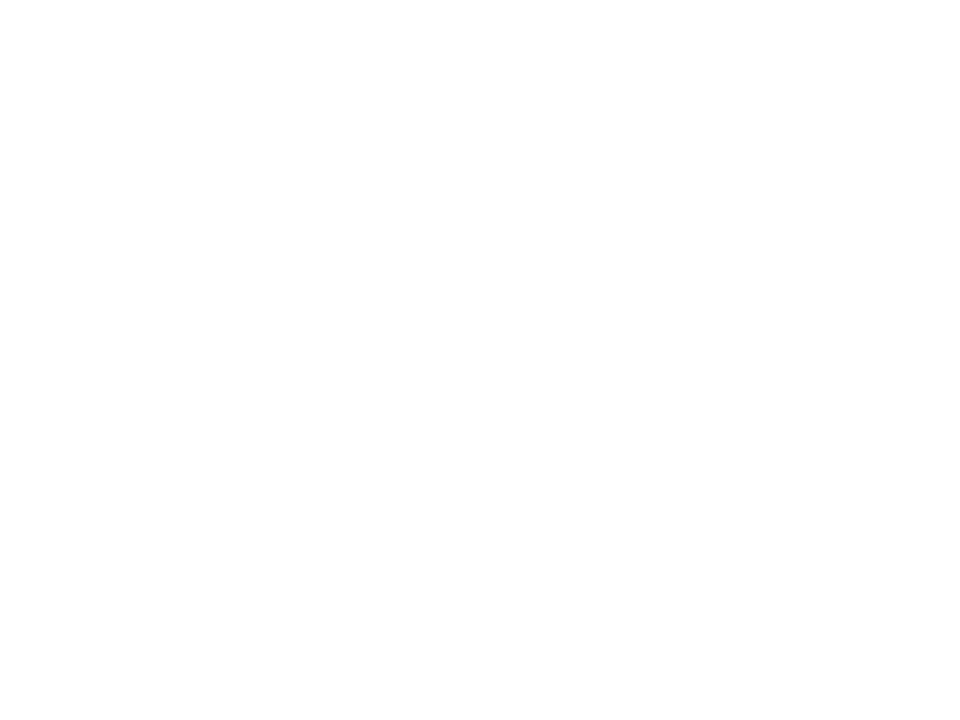

<IPython.core.display.Javascript object>


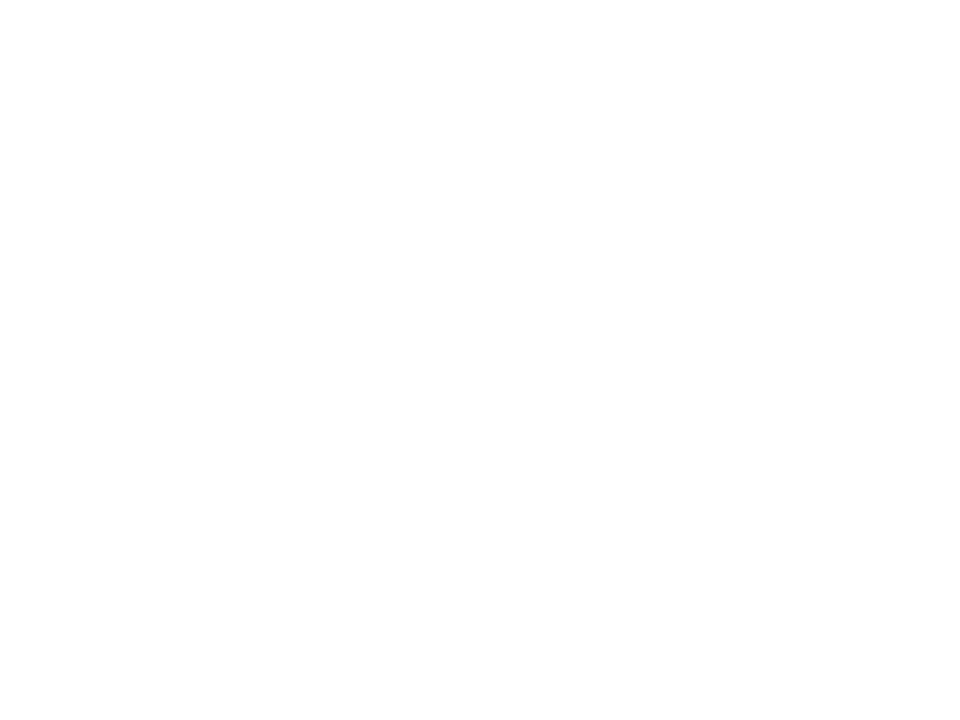

In [19]:
plt.figure()

## Playing ground

Catalogue of scatterers:

In [68]:
SCATTERERS_CATALOGUE

{'12639246600797894399': <__main__.MySurface at 0x7fdd8ad95550>,
 '17386778346896613912': <__main__.NeutralSurface at 0x7fdd8ad6e7c0>,
 '2753295789858012128': <__main__.BlackBodySurface at 0x7fdd8ad6e9a0>,
 '8444787382930178394': <__main__.LambertianGraySurface at 0x7fdd8ad888b0>,
 '13726343987531483060': <__main__.LambertianGrayAtmosphere at 0x7fdd68b5e7f0>,
 '14563942549452617125': <pryngles.scatterer.LambertianGrayAtmosphere at 0x7fdd68b5efd0>,
 '745845182321881531': <pryngles.scatterer.LambertianGraySurface at 0x7fdd68bbee20>,
 '14366390467869099438': <__main__.CustomSurface at 0x7fdd69d62910>}

Create system:

In [17]:
nspangles=50

sys=System()
S=sys.add(kind="Star",nspangles=nspangles,
          radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
P=sys.add(kind="Planet",parent=S,nspangles=nspangles,
          a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul,spangle_type=0)
R=sys.add(kind="Ring",parent=P,nspangles=nspangles,
          fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)

In [19]:
sys.spangle_scatterers

{2: (pryngles.scatterer.LambertianGrayAtmosphere,
  {'AS': 'albedo_gray_spherical'}),
 4: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 3: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 1: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 0: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 5: (pryngles.scatterer.BlackBodySurface, {}),
 6: (pryngles.scatterer.BlackBodySurface, {})}

Define a custom surface scatterer:

In [21]:
class CustomSurface(Scatterer):
    """Black body surface
    """
    def __init__(self,**params):
        if self.register(self,params):
            self.U=params["U"]
            self.V=params["V"]
    
    def get_albedo(self,eta,zeta,delta,lamb,**params):
        albedo=self.U*eta+self.V*eta
        return albedo

In [22]:
sys.spangle_scatterers[0]=(CustomSurface,dict(U="albedo_gray_normal",V="albedo_gray_spherical"))

In [23]:
sys.spangle_scatterers

{2: (pryngles.scatterer.LambertianGrayAtmosphere,
  {'AS': 'albedo_gray_spherical'}),
 4: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 3: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 1: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 0: (__main__.CustomSurface,
  {'U': 'albedo_gray_normal', 'V': 'albedo_gray_spherical'}),
 5: (pryngles.scatterer.BlackBodySurface, {}),
 6: (pryngles.scatterer.BlackBodySurface, {})}

In [25]:
sys.initialize_simulation()
sys.spangle_system()
sys.update_scatterers()

In [28]:
SCATTERERS_CATALOGUE

{'16022651069401228803': <__main__.MySurface at 0x7fa131e095e0>,
 '1855989805811391397': <__main__.NeutralSurface at 0x7fa133d6c070>,
 '8475508575066144198': <__main__.BlackBodySurface at 0x7fa133d6c2b0>,
 '8815132990889543432': <__main__.LambertianGraySurface at 0x7fa133eba3d0>,
 '1932213716405321316': <__main__.LambertianGrayAtmosphere at 0x7fa110f85190>,
 '17218226559613164855': <__main__.CustomSurface at 0x7fa111577310>,
 '11538896134797474558': <pryngles.scatterer.LambertianGraySurface at 0x7fa1114b4d90>}

In [29]:
sys.data[sys.data.name=="Planet"].scatterer

100    17218226559613164855
101    17218226559613164855
102    17218226559613164855
103    17218226559613164855
104    17218226559613164855
               ...         
195    17218226559613164855
196    17218226559613164855
197    17218226559613164855
198    17218226559613164855
199    17218226559613164855
Name: scatterer, Length: 100, dtype: object

In [31]:
SCATTERERS_CATALOGUE["17218226559613164855"].get_albedo(0.2,0.2,0,0)

0.4

### Previsualization comparison

In [ ]:
RP=sys.ensamble_system(lamb=90*Consts.deg,beta=90*Consts.deg,AL=0.5,AS=0.5)

<IPython.core.display.Javascript object>


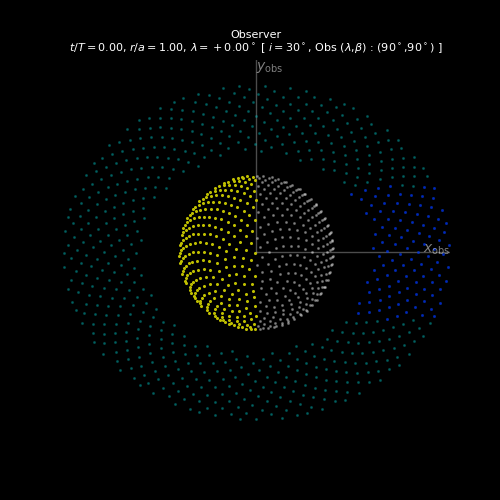

In [67]:
RP._plot["fs"]=5
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


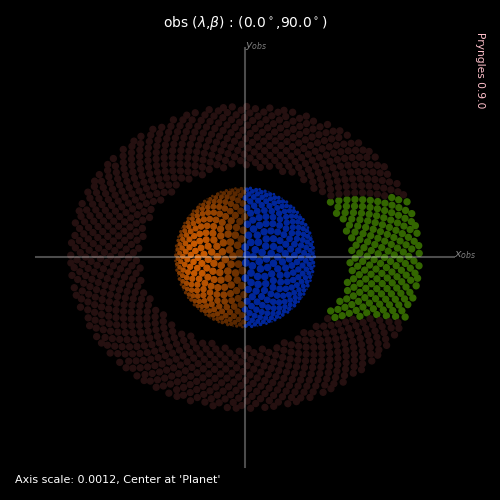

(0.18181818566061467, -6.003593414911354e-09)

In [68]:
sys.sg.plot2d(include=[P,R])

Number of spangles:

In [69]:
RP.Np,RP.Nr

(1000, 652)

In [70]:
P.sg.nspangles,R.sg.nspangles,(sys.data.name=="Planet").sum(),((sys.data.name=="Ring")&(~sys.data.hidden)).sum()

(987, 1064, 987, 1039)

Compared properties

In [71]:
RP.Rplanet,RP.Rstar,RP.Rp,RP.Rs,RP.Ri,RP.Re

(0.00040286669668487465,
 0.004650467260962157,
 0.08662929423602127,
 1.0,
 0.1299439413540319,
 0.21657323559005318)

In [72]:
sys.bodies["Planet"].radius,sys.bodies["Planet"].radius,\
sys.bodies["Planet"].radius/sys.bodies["Star"].radius,\
sys.bodies["Ring"].ri/sys.bodies["Star"].radius,sys.bodies["Ring"].re/sys.bodies["Star"].radius,

(0.00040286669668487465,
 0.00040286669668487465,
 0.08662929423602127,
 0.1299439413540319,
 0.21657323559005318)

Change stellar position:

<IPython.core.display.Javascript object>


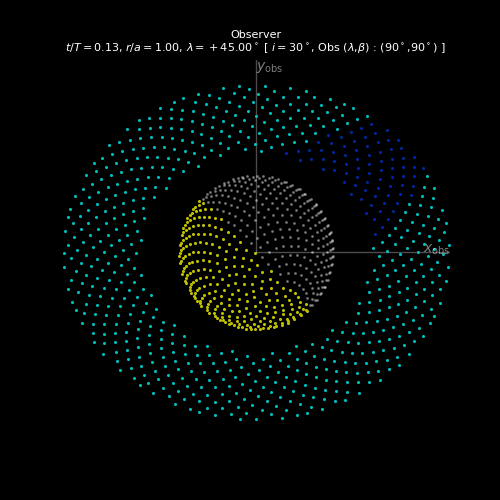

In [73]:
RP.changeStellarPosition(45*Consts.deg)
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


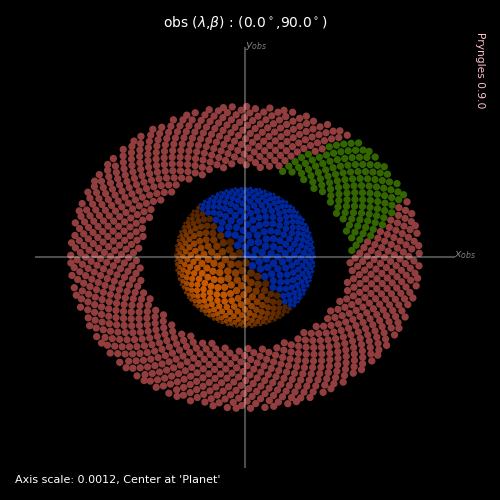

(0.1285648731490779, 0.12856486330305156)

In [74]:
sys.integrate(sys.sim.particles[1].P/8)
sys.update_perspective()
sys.sg.plot2d(include=[P,R])

<IPython.core.display.Javascript object>


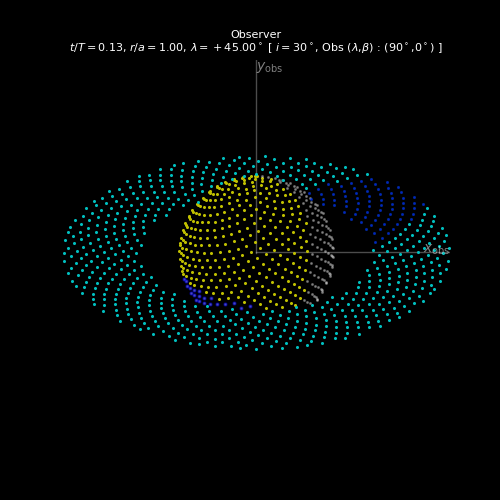

In [75]:
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


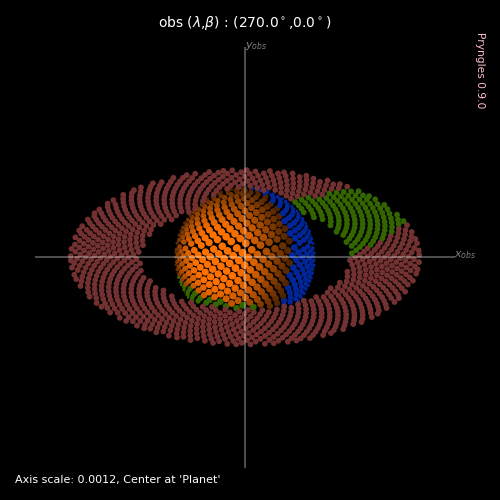

(0.1285648731490779, -8.861434635287762e-07)

In [76]:
sys.update_perspective(n_obs=Science.direction(-90,0))
sys.sg.plot2d(include=[P,R])

## Simple flux calculation

<IPython.core.display.Javascript object>


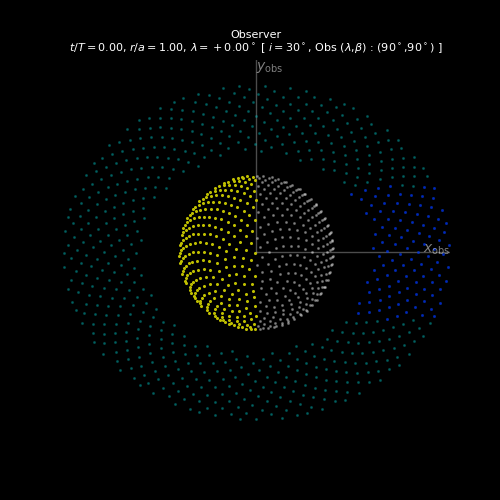

In [77]:
RP.changeStellarPosition(0.0*DEG)
RP.changeObserver([90.0*Consts.deg,90.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


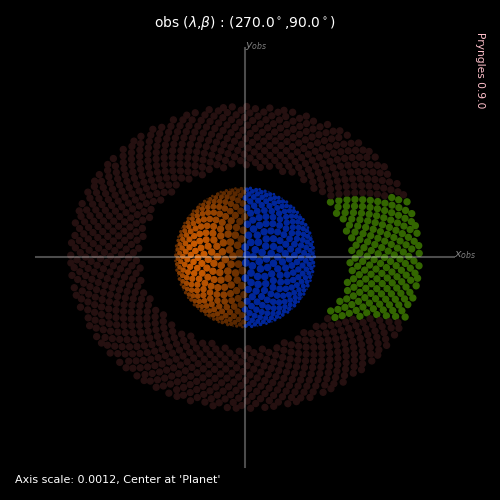

(0.18181818566061467, -6.003593434123292e-09)

In [78]:
sys.integrate(sys.sim.particles[1].P/12*0)
sys.update_perspective(n_obs=Science.direction(-90,90))
sys.sg.plot2d(include=[P,R])

In all calculations in the `RingedPlanet` interface the length units are stellar radii.

Now calculate flux from the planet:

In [79]:
RP.updateDiffuseReflection()
Flux_calculated=RP.Rip.sum()
Flux_calculated

1.1111755317854611e-07

The total expected flux without taking into account the law of reflection:

In [80]:
Flux_expected_tradition=(RP.Ap/2)/(4*np.pi*RP.rstar**2)
Flux_expected_tradition

5.071924228055711e-07

The flux reflected taking into account the law of reflection:

In [81]:
Flux_expected_real=(2*RP.Rp**2/3)/(4*np.pi*RP.rstar**2)*0.5
Flux_expected_real

1.0762957491768159e-07

Difference is due to the fact that Albedo is not exactly 0.5.

### System interface: areas

Area of the planet:

In [82]:
4*np.pi*P.radius**2

2.03954174648626e-06

Area computed from spangles:

In [83]:
cond=(sys.data.name=="Planet")
sys.data[cond].asp.sum()

2.0395417464862597e-06

If we use the areas from the light and observer point of view the value is slightly different due to discretization errors:

In [84]:
sys.data[cond].asp_obs.sum(),sys.data[cond].asp_luz.sum()

(2.035160338173772e-06, 2.0457642814974437e-06)

Area of the planet from above:

In [85]:
cond=(sys.data.name=="Planet")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

5.098854366215656e-07

In [86]:
cond=(sys.data.name=="Planet")&(sys.data.illuminated)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

5.098854366215648e-07

Actual transversal area:

In [87]:
np.pi*P.radius**2

5.09885436621565e-07

Area of the ring from above:

In [88]:
cond=(sys.data.name=="Ring")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

1.766294964535963e-06

In [89]:
cond=(sys.data.name=="Ring")&(sys.data.illuminated)&(~sys.data.hidden)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

-8.656742894061219e-23

Theoretical area of the ring:

In [90]:
np.pi*(R.re**2-R.ri**2)*np.cos(30*Const.deg)

1.7662949645359824e-06

### System interface: fluxes

<IPython.core.display.Javascript object>


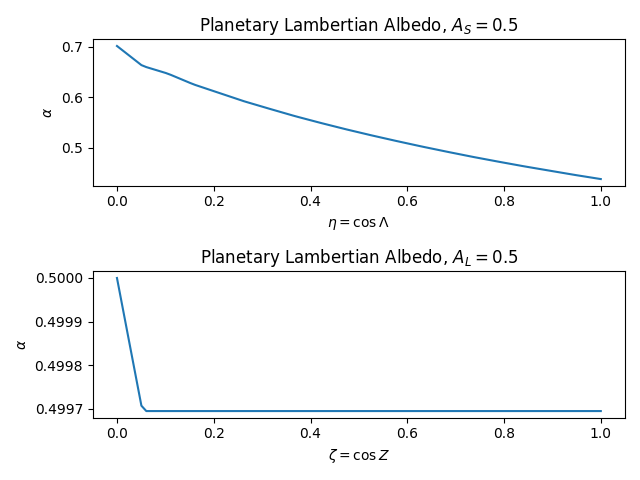

In [91]:
etas=np.linspace(0,1,100)
fig,axs=plt.subplots(2,1)

ax=axs[0]
ax.plot(etas,RP.getLambertianAlbedoPlanet(etas))
ax.set_xlabel(r"$\eta = \cos\Lambda$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_S=${RP.AS}");

ax=axs[1]
ax.plot(etas,RP.getLambertianAlbedoRing(etas))
ax.set_xlabel(r"$\zeta = \cos Z$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${RP.AL}");

fig.tight_layout()

In [ ]:
## Playing ground

Catalogue of scatterers:

SCATTERERS_CATALOGUE

Create system:

nspangles=50

sys=System()
S=sys.add(kind="Star",nspangles=nspangles,
          radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
P=sys.add(kind="Planet",parent=S,nspangles=nspangles,
          a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul,spangle_type=0)
R=sys.add(kind="Ring",parent=P,nspangles=nspangles,
          fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)

sys.spangle_scatterers

Define a custom surface scatterer:

class CustomSurface(Scatterer):
    """Black body surface
    """
    def __init__(self,**params):
        if self.register(self,params):
            self.U=params["U"]
            self.V=params["V"]
    
    def get_albedo(self,eta,zeta,delta,lamb,**params):
        albedo=self.U*eta+self.V*eta
        return albedo

sys.spangle_scatterers[0]=(CustomSurface,dict(U="albedo_gray_normal",V="albedo_gray_spherical"))

sys.spangle_scatterers

sys.initialize_simulation()
sys.spangle_system()
sys.update_scatterers()

SCATTERERS_CATALOGUE

sys.data[sys.data.name=="Planet"].scatterer

SCATTERERS_CATALOGUE["17218226559613164855"].get_albedo(0.2,0.2,0,0)



### Previsualization comparison

RP=sys.ensamble_system(lamb=90*Consts.deg,beta=90*Consts.deg,AL=0.5,AS=0.5)

RP._plot["fs"]=5
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.sg.plot2d(include=[P,R])

Number of spangles:

RP.Np,RP.Nr

P.sg.nspangles,R.sg.nspangles,(sys.data.name=="Planet").sum(),((sys.data.name=="Ring")&(~sys.data.hidden)).sum()

Compared properties

RP.Rplanet,RP.Rstar,RP.Rp,RP.Rs,RP.Ri,RP.Re

sys.bodies["Planet"].radius,sys.bodies["Planet"].radius,\
sys.bodies["Planet"].radius/sys.bodies["Star"].radius,\
sys.bodies["Ring"].ri/sys.bodies["Star"].radius,sys.bodies["Ring"].re/sys.bodies["Star"].radius,

Change stellar position:

RP.changeStellarPosition(45*Consts.deg)
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.integrate(sys.sim.particles[1].P/8)
sys.update_perspective()
sys.sg.plot2d(include=[P,R])

RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.update_perspective(n_obs=Science.direction(-90,0))
sys.sg.plot2d(include=[P,R])

## Simple flux calculation

RP.changeStellarPosition(0.0*DEG)
RP.changeObserver([90.0*Consts.deg,90.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.integrate(sys.sim.particles[1].P/12*0)
sys.update_perspective(n_obs=Science.direction(-90,90))
sys.sg.plot2d(include=[P,R])

In all calculations in the `RingedPlanet` interface the length units are stellar radii.

Now calculate flux from the planet:

RP.updateDiffuseReflection()
Flux_calculated=RP.Rip.sum()
Flux_calculated

The total expected flux without taking into account the law of reflection:

Flux_expected_tradition=(RP.Ap/2)/(4*np.pi*RP.rstar**2)
Flux_expected_tradition

The flux reflected taking into account the law of reflection:

Flux_expected_real=(2*RP.Rp**2/3)/(4*np.pi*RP.rstar**2)*0.5
Flux_expected_real

Difference is due to the fact that Albedo is not exactly 0.5.

### System interface: areas

Area of the planet:

4*np.pi*P.radius**2

Area computed from spangles:

cond=(sys.data.name=="Planet")
sys.data[cond].asp.sum()

If we use the areas from the light and observer point of view the value is slightly different due to discretization errors:

sys.data[cond].asp_obs.sum(),sys.data[cond].asp_luz.sum()

Area of the planet from above:

cond=(sys.data.name=="Planet")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

cond=(sys.data.name=="Planet")&(sys.data.illuminated)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

Actual transversal area:

np.pi*P.radius**2

Area of the ring from above:

cond=(sys.data.name=="Ring")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

cond=(sys.data.name=="Ring")&(sys.data.illuminated)&(~sys.data.hidden)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

Theoretical area of the ring:

np.pi*(R.re**2-R.ri**2)*np.cos(30*Const.deg)

### System interface: fluxes

etas=np.linspace(0,1,100)
fig,axs=plt.subplots(2,1)

ax=axs[0]
ax.plot(etas,RP.getLambertianAlbedoPlanet(etas))
ax.set_xlabel(r"$\eta = \cos\Lambda$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_S=${RP.AS}");

ax=axs[1]
ax.plot(etas,RP.getLambertianAlbedoRing(etas))
ax.set_xlabel(r"$\zeta = \cos Z$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${RP.AL}");

fig.tight_layout()